##### Master Degree in Computer Science and Data Science for Economics

# Classification problems

### Alfio Ferrara

Classification is the problem of assigning a label to an entity, such as a text, based on a set of features. It can be modeled as a function that provides a probability distribution over the target labels given the features, such as:

$$
f : X  \rightarrow \Delta_Y
$$

where $X$ denoted the features and $Y$ the labels. Thus, given a single input $x \in X$, $f(x)$ returns a vector $\mathbf{p}(x) \in \Delta_Y$ such that:

$$
\mathbf{p}(x) = \begin{bmatrix}
p_1(x) \\
p_2(x) \\
\dots \\
p_{\mid Y \mid}(x)
\end{bmatrix}
$$

provided that 

$$
\sum\limits_{i=1}^{\mid Y \mid} p_i(x) = 1,\ ;\ p_i(x) \geq 0 \forall i
$$

### Properties of classification
A classification problem can be:
- A **binary partition**: each input data point can be assigned to one label only among two possible labels
- A **soft binary classification**: each input data point can be assigned to one or two labels among two possible labels
- A **partition**, called **multi-class classification**: each input data point can be assigned to one class only among many
- A **a soft classification**, called **multi-label classification**: each input data point can be assigne to multiple labels among many

## Classify recipes by ingredients

In [1]:
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

In [3]:
print(len(data))
data[0]

65212


{'ingredients': ['zucchini',
  'yellow squash',
  'diced tomatoes',
  'onion',
  'garlic',
  'green bell pepper',
  'italian seasoning',
  'water',
  'salt and pepper'],
 'category': 'italian'}

In [4]:
labels

['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'polish']

### Encoding features and labels

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
tokenizer = lambda x: x.split("|")
ingredients_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True, min_df=20)
labels_encoder = CountVectorizer(tokenizer=tokenizer, token_pattern=None, binary=True)

In [10]:
X = ingredients_encoder.fit_transform(["|".join(x['ingredients']) for x in data]).toarray()
y = labels_encoder.fit_transform([x[label_field] for x in data]).toarray()

In [11]:
print(f"Features: {X.shape}")
print(f"Labels: {y.shape}")

Features: (65212, 2345)
Labels: (65212, 7)


## Check for the dates properties and split in train and test datasets

In [14]:
from sklearn.model_selection import train_test_split

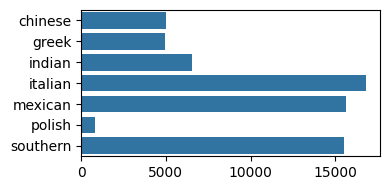

In [15]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.barplot(x=y.sum(axis=0), y=labels_encoder.get_feature_names_out(), ax=ax)
plt.tight_layout()
plt.show()

In [16]:
labels = labels_encoder.get_feature_names_out()
y_true = [labels[int(np.where(a == 1)[0][0])] for a in y]
y_true[:5]

['italian', 'italian', 'italian', 'mexican', 'mexican']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=.7)

## Classic classifiers

In [18]:
from bornrule import BornClassifier

In [19]:
born = BornClassifier()
born.fit(X_train, y_train)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


BornClassifier()

In [20]:
y_pred = born.predict(X_test)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [21]:
y_pred[:5]

array(['southern', 'indian', 'indian', 'mexican', 'greek'], dtype='<U8')

## Evaluation

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [24]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     chinese       0.70      0.92      0.79      1522
       greek       0.55      0.77      0.64      1473
      indian       0.81      0.86      0.84      2002
     italian       0.85      0.78      0.82      5045
     mexican       0.87      0.84      0.86      4622
      polish       0.14      0.74      0.23       264
    southern       0.83      0.51      0.63      4636

    accuracy                           0.75     19564
   macro avg       0.68      0.78      0.69     19564
weighted avg       0.80      0.75      0.76     19564



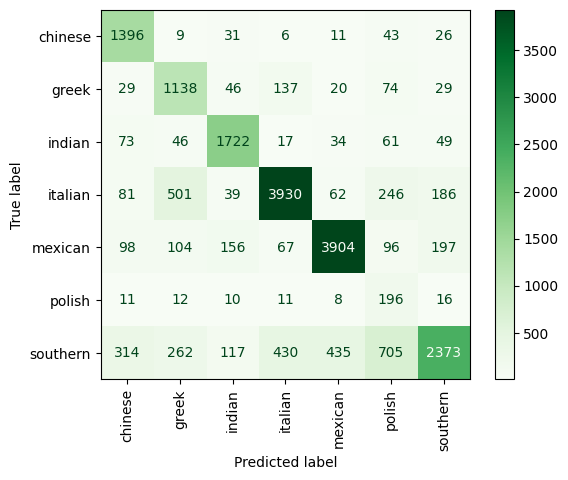

In [25]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.show()

## Explainability

### Local explanation

In [39]:
test_recipe = ['potatoes', 'onions', 'salt', 'mushrooms', 'olive oil', 'soy sauce']
vector = ingredients_encoder.transform(["|".join(test_recipe)]).toarray()
print(born.predict(vector)[0])
print(pd.Series(born.predict_proba(vector)[0], index=labels))

chinese
chinese     0.577885
greek       0.096788
indian      0.059441
italian     0.069754
mexican     0.047669
polish      0.073993
southern    0.074469
dtype: float64


/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [40]:
local_explain = pd.DataFrame(born.explain(vector), index=ingredients_encoder.get_feature_names_out(), columns=labels)
local_explain.head()

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


,chinese,greek,indian,italian,mexican,polish,southern
,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-inch flour tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2%25 low-fat milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6-inch corn tortillas,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
local_explain['chinese'].sort_values(ascending=False).head(10)

soy sauce         0.068501
olive oil         0.004845
potatoes          0.002148
mushrooms         0.001488
onions            0.001012
salt              0.000768
                  0.000000
parsnips          0.000000
parsley           0.000000
parsley flakes    0.000000
Name: chinese, dtype: float64

### Global explanation

In [36]:
global_explain = pd.DataFrame(born.explain(X_test), index=ingredients_encoder.get_feature_names_out(), columns=labels)

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [37]:
global_explain.head()

,chinese,greek,indian,italian,mexican,polish,southern
,0.000499,0.000581,0.000541,0.000626,0.000732,0.000710,0.000505
1%25 low-fat milk,0.001624,0.001920,0.001615,0.002900,0.001981,0.000000,0.001701
10-inch flour tortillas,0.000000,0.000000,0.002849,0.000000,0.010548,0.000000,0.001978
2%25 low-fat milk,0.000930,0.001165,0.002042,0.002281,0.003131,0.003363,0.003351
6-inch corn tortillas,0.000000,0.000000,0.000000,0.001728,0.008891,0.000000,0.002396


In [45]:
global_explain.sort_values(by='indian', ascending=False).head(10)

,chinese,greek,indian,italian,mexican,polish,southern
garam masala,0.040958,0.000000,0.558761,0.000000,0.000000,0.000000,0.024066
turmeric,0.065774,0.046254,0.439708,0.018976,0.062421,0.073227,0.065872
ghee,0.000000,0.024156,0.416222,0.000000,0.013593,0.000000,0.009954
curry powder,0.128334,0.034108,0.406930,0.036020,0.036103,0.000000,0.078647
turmeric powder,0.026162,0.000000,0.402120,0.000000,0.010934,0.000000,0.000000
chili powder,0.116600,0.071263,0.385396,0.084171,0.497078,0.072412,0.227462
cumin seed,0.000000,0.052082,0.385297,0.025129,0.093018,0.054523,0.031234
fresh ginger,0.470157,0.030295,0.376666,0.038469,0.045896,0.000000,0.083234
green chilies,0.063839,0.035998,0.361619,0.027722,0.330880,0.048057,0.076153
red chili powder,0.035623,0.000000,0.359307,0.000000,0.064882,0.000000,0.020737
